Resolução deafio clustering, Gustavo Alves

Dataset:  Student Habits vs Academic Performance (link: https://www.kaggle.com/datasets/jayaantanaath/student-habits-vs-academic-performance/data)

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

---

1) Observação dos dados e formulação de hipóteses:

In [50]:
df = pd.read_csv('archive/student_habits_performance.csv')
df.head()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


In [51]:
df.shape

(1000, 16)

Temos um dataset de estudantes que lista dados com enfoque nos seus hábitos, como dieta e frequência de exercício, dados pessoais, como idade e gênero, e na nota de um exame. No total, temos 1000 estudantes. 


Hipótese: Á primeira vista, é possível pensar em dois pilares de classificação: saúde(qualidade da dieta, sono, exercício, saúde mental, ...) e performance(horas de estudo diário, participação em atividades extracurriculares, nota exame, ...). Intuitivamente, saúde e performance são áreas correlatas, então deve ser possível estabelecer uma classificação que relacione todos esses dados. É difícil estimar uma quantidade de grupos, pensando somente em performance é possível pensar em poucos clusters como [bom, médio, ruim], mas adicionar o contexto dos hábitos/saúde nisso não é trivial.

Sobre os dados, imagino que no contexto da performance as métricas mais importantes para separação desses grupos serão o nível de educação dos pais, porque a criação tem uma importância grande, e o número de horas estudadas diariamente. No contexto dos hábitos, sono e exercício devem ser as mais importantes.

---

2) EDA

Primeiramente, vamos analisar se temos dados faltantes.

In [52]:
df.isna().sum()

student_id                        0
age                               0
gender                            0
study_hours_per_day               0
social_media_hours                0
netflix_hours                     0
part_time_job                     0
attendance_percentage             0
sleep_hours                       0
diet_quality                      0
exercise_frequency                0
parental_education_level         91
internet_quality                  0
mental_health_rating              0
extracurricular_participation     0
exam_score                        0
dtype: int64

Temos 91 dados faltantes de uma categoria que pela minha hipótese, deve ter uma relação grande com outras variáveis. Para ter certeza, vamos analisar uma matriz de correlação dos dados:

In [53]:
map_dieta = {
    'Poor': 0,
    'Fair': 1,
    'Good': 2
}

map_educ = {
    'High School': 0,
    'Bachelor': 1,
    'Master': 2
}

map_internet = {
    'Poor': 0,
    'Average': 1,
    'Good': 2
}

df_numeric = df.copy()

df_numeric['diet_quality'] = df_numeric['diet_quality'].map(map_dieta)
df_numeric['parental_education_level'] = df_numeric['parental_education_level'].map(map_educ)
df_numeric['internet_quality'] = df_numeric['internet_quality'].map(map_internet)

df_numeric.head()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,1,6,2.0,1,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,2,6,0.0,1,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,0,1,0.0,0,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,0,4,2.0,2,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,1,3,2.0,2,1,No,66.4


In [54]:
for col in df_numeric.columns:
    if df_numeric[col].dtype == 'object':
        encoder = LabelEncoder()
        df_numeric[col] = encoder.fit_transform(df_numeric[col])

df_numeric.head()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,0,23,0,0.0,1.2,1.1,0,85.0,8.0,1,6,2.0,1,8,1,56.2
1,1,20,0,6.9,2.8,2.3,0,97.3,4.6,2,6,0.0,1,8,0,100.0
2,2,21,1,1.4,3.1,1.3,0,94.8,8.0,0,1,0.0,0,1,0,34.3
3,3,23,0,1.0,3.9,1.0,0,71.0,9.2,0,4,2.0,2,1,1,26.8
4,4,19,0,5.0,4.4,0.5,0,90.9,4.9,1,3,2.0,2,1,0,66.4


In [55]:
df_numeric.describe()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
count,1000.000000,1000.0000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,909.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,20.4980,0.561000,3.55010,2.505500,1.819700,0.215000,84.131700,6.470100,1.19300,3.042000,0.752475,1.285000,5.438000,0.318000,69.601500
std,288.819436,2.3081,0.574987,1.46889,1.172422,1.075118,0.411028,9.399246,1.226377,0.72545,2.025423,0.744515,0.726845,2.847501,0.465932,16.888564
min,0.000000,17.0000,0.000000,0.00000,0.000000,0.000000,0.000000,56.000000,3.200000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,18.400000
25%,249.750000,18.7500,0.000000,2.60000,1.700000,1.000000,0.000000,78.000000,5.600000,1.00000,1.000000,0.000000,1.000000,3.000000,0.000000,58.475000
50%,499.500000,20.0000,1.000000,3.50000,2.500000,1.800000,0.000000,84.400000,6.500000,1.00000,3.000000,1.000000,1.000000,5.000000,0.000000,70.500000
75%,749.250000,23.0000,1.000000,4.50000,3.300000,2.525000,0.000000,91.025000,7.300000,2.00000,5.000000,1.000000,2.000000,8.000000,1.000000,81.325000
max,999.000000,24.0000,2.000000,8.30000,7.200000,5.400000,1.000000,100.000000,10.000000,2.00000,6.000000,2.000000,2.000000,10.000000,1.000000,100.000000


In [56]:
correlacao = df_numeric.corr()[['parental_education_level']]
correlacao

,parental_education_level
student_id,-0.013073
age,0.027578
gender,-0.036988
study_hours_per_day,0.001925
social_media_hours,-0.016840
netflix_hours,-0.020531
part_time_job,-0.034099
attendance_percentage,-0.029672
sleep_hours,0.017303
diet_quality,-0.031019


Não tivemos nenhuma correlação forte detectada, o que não necessariamente indica que nossa hipótese estava errada, apenas que não há uma relação linear forte. Vamos fazer uma análise mais estatística com 2 variáveis, estudo diário(segunda maior correlação positiva) e nota do exame(surpreendentemente a terceira mais negativa): 

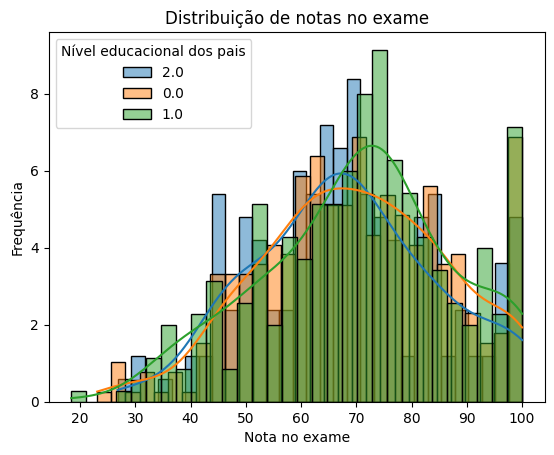

In [57]:
grupos = df_numeric['parental_education_level'].unique()

for grupo in grupos:
    sns.histplot(df_numeric[df_numeric['parental_education_level'] == grupo]['exam_score'], kde=True, label = grupo, stat='percent', bins=30)
    plt.title('Distribuição de notas no exame')
    plt.xlabel('Nota no exame')
    plt.ylabel('Frequência')
    plt.title(f'Distribuição de notas no exame')
    plt.legend(title='Nível educacional dos pais')

Temos 3 gráficos muito parecidos. Agora vamos ver o estudo diário:

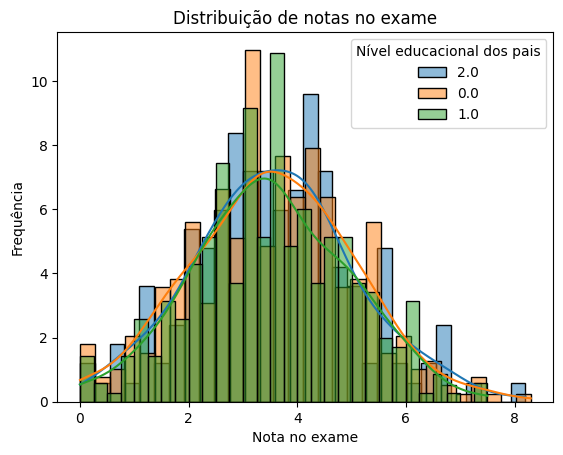

In [58]:
grupos = df_numeric['parental_education_level'].unique()

for grupo in grupos:
    sns.histplot(df_numeric[df_numeric['parental_education_level'] == grupo]['study_hours_per_day'], kde=True, label = grupo, stat='percent', bins=30)
    plt.title('Distribuição de notas no exame')
    plt.xlabel('Nota no exame')
    plt.ylabel('Frequência')
    plt.title(f'Distribuição de notas no exame')
    plt.legend(title='Nível educacional dos pais')

Outra amostra de gráficos muito parecida. O que podemos concluir é que talvez o nível de educação parental não seja tão relevante no contexto educacional, algo extremamente contraituitivo. Ainda assim, creio que mesmo não óbvia, há uma relação entre esses dados no contexto educacional, então não vou tratar com preenchimento da média ou da moda, e sim dos k-vizinhos mais próximos.

In [59]:
escala = StandardScaler()
df_escala = escala.fit_transform(df_numeric)

imputer = KNNImputer(n_neighbors=3)
df_imputed = imputer.fit_transform(df_escala)

df_imputed = pd.DataFrame(df_imputed, columns=df_numeric.columns)
df_revertido = escala.inverse_transform(df_imputed)
df_revertido = pd.DataFrame(df_revertido, columns=df_numeric.columns)

df_revertido.describe()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
count,1000.000000,1000.0000,1000.000000,1000.00000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.00000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,20.4980,0.561000,3.55010,2.505500,1.819700,2.150000e-01,84.131700,6.470100,1.19300,3.042000,7.536667e-01,1.285000,5.438000,0.318000,69.601500
std,288.819436,2.3081,0.574987,1.46889,1.172422,1.075118,4.110279e-01,9.399246,1.226377,0.72545,2.025423,7.232324e-01,0.726845,2.847501,0.465932,16.888564
min,0.000000,17.0000,0.000000,0.00000,0.000000,0.000000,-2.775558e-17,56.000000,3.200000,0.00000,0.000000,-1.110223e-16,0.000000,1.000000,0.000000,18.400000
25%,249.750000,18.7500,0.000000,2.60000,1.700000,1.000000,-2.775558e-17,78.000000,5.600000,1.00000,1.000000,-1.110223e-16,1.000000,3.000000,0.000000,58.475000
50%,499.500000,20.0000,1.000000,3.50000,2.500000,1.800000,-2.775558e-17,84.400000,6.500000,1.00000,3.000000,1.000000e+00,1.000000,5.000000,0.000000,70.500000
75%,749.250000,23.0000,1.000000,4.50000,3.300000,2.525000,-2.775558e-17,91.025000,7.300000,2.00000,5.000000,1.000000e+00,2.000000,8.000000,1.000000,81.325000
max,999.000000,24.0000,2.000000,8.30000,7.200000,5.400000,1.000000e+00,100.000000,10.000000,2.00000,6.000000,2.000000e+00,2.000000,10.000000,1.000000,100.000000


In [60]:
df_revertido['parental_education_level'] = df_revertido['parental_education_level'].round().astype(int)
df_revertido['parental_education_level'].unique()

array([2, 0, 1])

In [61]:
df_revertido['part_time_job'] = df_revertido['part_time_job'].round().astype(int)
df_revertido['part_time_job'].unique()

array([0, 1])

In [62]:
df_revertido.describe()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
count,1000.000000,1000.0000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,20.4980,0.561000,3.55010,2.505500,1.819700,0.215000,84.131700,6.470100,1.19300,3.042000,0.753000,1.285000,5.438000,0.318000,69.601500
std,288.819436,2.3081,0.574987,1.46889,1.172422,1.075118,0.411028,9.399246,1.226377,0.72545,2.025423,0.731113,0.726845,2.847501,0.465932,16.888564
min,0.000000,17.0000,0.000000,0.00000,0.000000,0.000000,0.000000,56.000000,3.200000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,18.400000
25%,249.750000,18.7500,0.000000,2.60000,1.700000,1.000000,0.000000,78.000000,5.600000,1.00000,1.000000,0.000000,1.000000,3.000000,0.000000,58.475000
50%,499.500000,20.0000,1.000000,3.50000,2.500000,1.800000,0.000000,84.400000,6.500000,1.00000,3.000000,1.000000,1.000000,5.000000,0.000000,70.500000
75%,749.250000,23.0000,1.000000,4.50000,3.300000,2.525000,0.000000,91.025000,7.300000,2.00000,5.000000,1.000000,2.000000,8.000000,1.000000,81.325000
max,999.000000,24.0000,2.000000,8.30000,7.200000,5.400000,1.000000,100.000000,10.000000,2.00000,6.000000,2.000000,2.000000,10.000000,1.000000,100.000000


In [63]:
df_revertido.head()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,0.0,23.0,0.0,0.0,1.2,1.1,0,85.0,8.0,1.0,6.0,2,1.0,8.0,1.0,56.2
1,1.0,20.0,0.0,6.9,2.8,2.3,0,97.3,4.6,2.0,6.0,0,1.0,8.0,0.0,100.0
2,2.0,21.0,1.0,1.4,3.1,1.3,0,94.8,8.0,0.0,1.0,0,0.0,1.0,0.0,34.3
3,3.0,23.0,0.0,1.0,3.9,1.0,0,71.0,9.2,0.0,4.0,2,2.0,1.0,1.0,26.8
4,4.0,19.0,0.0,5.0,4.4,0.5,0,90.9,4.9,1.0,3.0,2,2.0,1.0,0.0,66.4


Vamos ver se a distribuição que analisamos anteriormente se mantém:

In [64]:
freq = df['parental_education_level'].value_counts()
print(freq)

freq = df_revertido['parental_education_level'].value_counts()
print(freq)

parental_education_level
High School    392
Bachelor       350
Master         167
Name: count, dtype: int64
parental_education_level
0    421
1    405
2    174
Name: count, dtype: int64


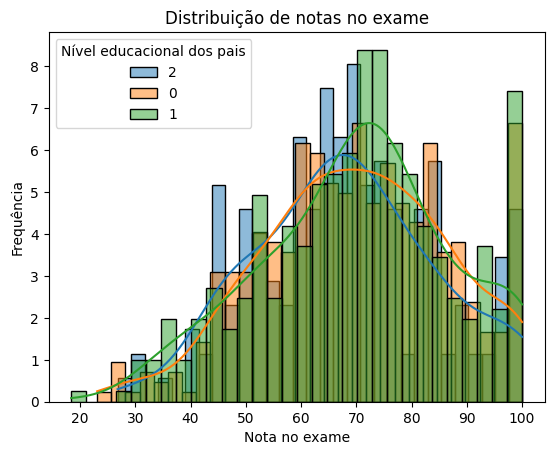

In [65]:
grupos = df_revertido['parental_education_level'].unique()

for grupo in grupos:
    sns.histplot(df_revertido[df_revertido['parental_education_level'] == grupo]['exam_score'], kde=True, label = grupo, stat='percent', bins=30)
    plt.title('Distribuição de notas no exame')
    plt.xlabel('Nota no exame')
    plt.ylabel('Frequência')
    plt.title(f'Distribuição de notas no exame')
    plt.legend(title='Nível educacional dos pais')

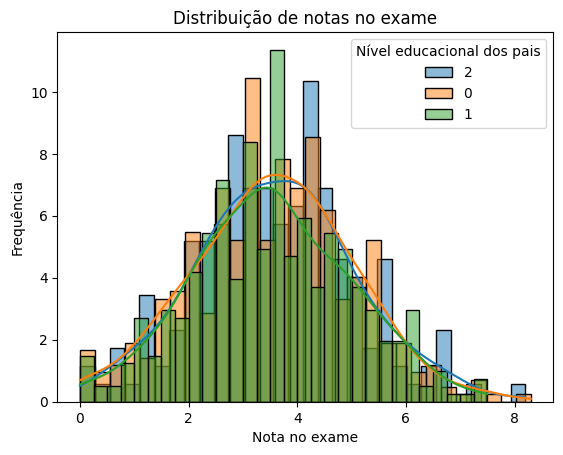

In [66]:
grupos = df_revertido['parental_education_level'].unique()

for grupo in grupos:
    sns.histplot(df_revertido[df_revertido['parental_education_level'] == grupo]['study_hours_per_day'], kde=True, label = grupo, stat='percent', bins=30)
    plt.title('Distribuição de notas no exame')
    plt.xlabel('Nota no exame')
    plt.ylabel('Frequência')
    plt.title(f'Distribuição de notas no exame')
    plt.legend(title='Nível educacional dos pais')

Os gráficos de distribuição estão parecidos( oque já era esperado, pois não eram tantos dados faltantes, menos de 10%), então vamos manter essa estratégia de preenchimento de dados.

Agora, vamos analisar se temos muitos outliers nos dados:

In [67]:
df_revertido.describe()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
count,1000.000000,1000.0000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,20.4980,0.561000,3.55010,2.505500,1.819700,0.215000,84.131700,6.470100,1.19300,3.042000,0.753000,1.285000,5.438000,0.318000,69.601500
std,288.819436,2.3081,0.574987,1.46889,1.172422,1.075118,0.411028,9.399246,1.226377,0.72545,2.025423,0.731113,0.726845,2.847501,0.465932,16.888564
min,0.000000,17.0000,0.000000,0.00000,0.000000,0.000000,0.000000,56.000000,3.200000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,18.400000
25%,249.750000,18.7500,0.000000,2.60000,1.700000,1.000000,0.000000,78.000000,5.600000,1.00000,1.000000,0.000000,1.000000,3.000000,0.000000,58.475000
50%,499.500000,20.0000,1.000000,3.50000,2.500000,1.800000,0.000000,84.400000,6.500000,1.00000,3.000000,1.000000,1.000000,5.000000,0.000000,70.500000
75%,749.250000,23.0000,1.000000,4.50000,3.300000,2.525000,0.000000,91.025000,7.300000,2.00000,5.000000,1.000000,2.000000,8.000000,1.000000,81.325000
max,999.000000,24.0000,2.000000,8.30000,7.200000,5.400000,1.000000,100.000000,10.000000,2.00000,6.000000,2.000000,2.000000,10.000000,1.000000,100.000000


Analisando por cima, não parece ter outliers significativos, todos os dados variam em um intervaloi bem especificado. Talvez a gente possa ter um outliner quando analisamos um certo grupo(exemplo: entre o grupo dos alunos que estudam menos de 2 horas por dia, um tirou uma nota acima de 90), mas fazer uma análise de todos esses grupos que podem ter outliers é algo inviável, até porque podemos faezr grupos de 2, 3, ... , variáveis, resultando em diversos grupos com possíveis outliers.

---

3) Revisão de hipóteses

Vamos gerar novamente nossas correlações:

In [68]:
correlacao = df_revertido.corr()
correlacao

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
student_id,1.000000,-0.028505,0.001389,-0.026012,-0.037516,-0.030793,0.049703,-0.072613,-0.065830,-0.020799,-0.007175,-0.018713,0.006173,0.037973,0.027478,-0.021489
age,-0.028505,1.000000,0.032902,0.003971,-0.009151,-0.001174,-0.011680,-0.026055,0.037482,0.004117,-0.003836,0.031443,0.007799,-0.045101,-0.004993,-0.008907
gender,0.001389,0.032902,1.000000,-0.016126,0.006555,0.033111,0.035515,-0.021779,0.018843,0.004144,0.052808,-0.051036,-0.033257,-0.003496,-0.001487,-0.002406
study_hours_per_day,-0.026012,0.003971,-0.016126,1.000000,0.020282,-0.031158,-0.029133,0.026264,-0.027757,0.033377,-0.028701,0.005755,0.014459,-0.003768,-0.003264,0.825419
social_media_hours,-0.037516,-0.009151,0.006555,0.020282,1.000000,0.011477,0.021224,0.040479,0.018236,0.011344,-0.037319,-0.011843,0.036805,0.001496,-0.018597,-0.166733
netflix_hours,-0.030793,-0.001174,0.033111,-0.031158,0.011477,1.000000,0.009207,-0.002092,-0.000935,-0.009885,-0.006448,-0.008066,0.039563,0.008034,-0.005125,-0.171779
part_time_job,0.049703,-0.011680,0.035515,-0.029133,0.021224,0.009207,1.000000,-0.041771,0.001645,0.035266,-0.021679,-0.032961,0.009130,0.013539,-0.022841,-0.026608
attendance_percentage,-0.072613,-0.026055,-0.021779,0.026264,0.040479,-0.002092,-0.041771,1.000000,0.013756,-0.058621,-0.007857,-0.019908,-0.039903,-0.018745,-0.017778,0.089836
sleep_hours,-0.065830,0.037482,0.018843,-0.027757,0.018236,-0.000935,0.001645,0.013756,1.000000,-0.034800,0.019769,0.011962,0.002045,-0.006508,0.027693,0.121683
diet_quality,-0.020799,0.004117,0.004144,0.033377,0.011344,-0.009885,0.035266,-0.058621,-0.034800,1.000000,0.005378,-0.017607,0.037958,0.027362,-0.030722,0.015018


In [69]:
correlacao = df_revertido.corr().abs().unstack() 
correlacao = correlacao[correlacao < 1]  
correlacao_ordenada = correlacao.sort_values(ascending=False)

print(correlacao_ordenada[0:10])

study_hours_per_day   exam_score              0.825419
exam_score            study_hours_per_day     0.825419
mental_health_rating  exam_score              0.321523
exam_score            mental_health_rating    0.321523
                      netflix_hours           0.171779
netflix_hours         exam_score              0.171779
social_media_hours    exam_score              0.166733
exam_score            social_media_hours      0.166733
exercise_frequency    exam_score              0.160107
exam_score            exercise_frequency      0.160107
dtype: float64


A hipótese de que o estudo diário teria uma alta relação com a nota final manteve-se, sendo a maior correlação presente nos nossos dados. Porém, curiosamente, não temos correlações dos hábitos(por exemplo: exercício e saúde mental) no topo, endo uma grande prevalencia de hábitos com a nota final, algo inesperado.

Além disso, percebemos uma grande quantidade de relações não significativas nos gráficos, o que sustenta a hipótese de difcícil análise desse dataset devido à interrelação entre saúde e performance intelectual.

---

4) Algoritmo K-Means

De acordo com o livro Data Cience do Zero, o algoritmo K-Means pode ser resumido da seguinte forma:


1. Comece com um conjunto de k-means, que são pontos no
espaço d-dimensional;
2. Atribua cada ponto à média mais próxima dele;
3. Se não for alterada a atribuição de nenhum ponto, pare e
mantenha os grupos;
4. Se a atribuição de algum ponto for alterada, compute
novamente as médias e retorne à etapa 2

Vamos criar uma clase KMeans, semelhance à do sklearn, com nossas próprias funções:

In [70]:
class KMeans:

    # define número de clusters e o máximo de iterações
    def __init__(self, n_clusters, max_itr):
        self.n_clusters = n_clusters
        self.max_itr = max_itr

    # função para encaixar cada ponto x no centroide mais próximo
    def _encaixar_centroides(self, X):
        labels = []
        for x in X:
            distancias = []
            for centroide in self.centroides:
                distancia = np.sqrt(np.sum((x - centroide) ** 2))
                distancias.append(distancia)

            indice_mais_proximo = np.argmin(distancias)
            labels.append(indice_mais_proximo)
        return np.array(labels)

    # função para atualizar os centróides com a média dos pontos
    def _update_centroides(self, X, labels):
        novos_centroides = []
        for i in range(self.n_clusters):
            pontos_do_cluster = X[labels == i]
            if len(pontos_do_cluster) > 0:
                novo_centroide = pontos_do_cluster.mean(axis=0)
                novos_centroides.append(novo_centroide)
            else:
                novo_centroide = X[np.random.randint(0, X.shape[0])]
                novos_centroides.append(novo_centroide)
        return np.array(novos_centroides)

    # lógica do KMeans
    def fit(self, X):
        self.centroides = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]
        for i in range(self.max_itr):

            labels = self._encaixar_centroides(X)
            novos_centroides = self._update_centroides(X, labels)

            if np.all(self.centroides == novos_centroides):
                break
            
            self.centroides = novos_centroides
            
        self.labels_ = self._encaixar_centroides(X) 
        self.inertia_ = np.sum([
            np.sum((X[self.labels_ == i] - centroide) ** 2)
            for i, centroide in enumerate(self.centroides)
        ])

    

In [71]:
X = np.array(df_revertido)
X

array([[  0. ,  23. ,   0. , ...,   8. ,   1. ,  56.2],
       [  1. ,  20. ,   0. , ...,   8. ,   0. , 100. ],
       [  2. ,  21. ,   1. , ...,   1. ,   0. ,  34.3],
       ...,
       [997. ,  20. ,   1. , ...,   9. ,   1. ,  64.4],
       [998. ,  24. ,   1. , ...,   1. ,   0. ,  69.7],
       [999. ,  19. ,   0. , ...,   8. ,   0. ,  74.9]], shape=(1000, 16))

---
5) Definir o valor de K(n_clusters)

Para definir o número de clusters ideal, dentro da função fit() da classe KMeans foi criada uma variável que armazena a inércia das labels, para assim conseguirmos tal número

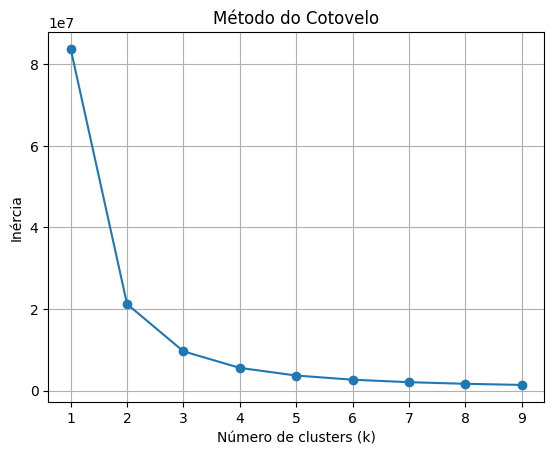

In [76]:
inertias = []
for k in range(1, 10):
    modelo = KMeans(k, 100)
    modelo.fit(X)
    inertias.append(modelo.inertia_)

plt.plot(range(1, 10), inertias, marker='o')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inércia")
plt.title("Método do Cotovelo")
plt.grid(True)
plt.show()

A partir desse gráfico, fica nítido a dobra no ponto onde K=3, portanto nosso número de klusters será 3!

In [ ]:
modelo = KMeans(n_clusters=k, max_itr=100)
modelo.fit(X)

---
6) Conclusão final

---
7) Algoritmos  DBSCAM e Hierarquical Clustering

---
8) Algoritmo State-of-the-art